# Using Muon with BD Rhapsody ATAC-Seq single-cell data

This is an example of how to use the [Muon](https://muon-tutorials.readthedocs.io/en/latest/index.html) package to analyze single-cell ATAC-Seq data produced by the BD Rhapsody Sequence Analysis Pipeline.  The data used in this example can be found in this demo data result: [AT209-72h-fresh (2.1GB)](https://bd-rhapsody-public.s3.amazonaws.com/Rhapsody-Demo-Data/AT209-72h-fresh.zip)
This tutorial is adapted from [this](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) original muon tutorial.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load packages used in this tutorial
import pandas as pd
import anndata as ad
import muon as mu
from muon import MuData
import scanpy as sc
# Import a module with ATAC-seq-related functions
from muon import atac as ac
import numpy as np

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()             # Print the package versions that are installed

scanpy==1.9.8 anndata==0.10.7 umap==0.5.3 numpy==1.24.2 scipy==1.10.1 pandas==2.2.2 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.10


### The Rhapsody Sequence Analysis Pipeline (>=2.2) generates an integrated muon output (.h5mu), so it's very easy to load the result cell-by-gene or cell-by-peak matrix, and associated annotations.

Muon uses multimodal data (MuData) objects as containers for multimodal data; each modality is an individual anndata object. `mdata` here is a MuData object that has been created directly from an AnnData object with multiple features types.  

In [3]:
mdata = mu.read("AT209-72h-fresh-Combined.h5mu")
# View the content of this muon object
mdata

MuData object with n_obs × n_vars = 2584 × 125295
  1 modality
    atac:	2584 x 125295
      obs:	'Cell_Type_Experimental'
      uns:	'Pipeline_Inputs', 'Pipeline_Metrics', 'atac'
      obsm:	'X_tsne', 'X_umap'

Since this was an ATAC-Seq only Rhapsody experiment, there is only 1 modality.  If this was a multi-omic RNA-Seq + ATAC-Seq experiment, one would see 2 separate modalities.

## Processing chromatin accessibility

### ATAC

We will only be working with the ATAC modality, so we can directly access the ATAC anndata object using `mdata.mod`:

In [4]:
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 2584 × 125295
    obs: 'Cell_Type_Experimental'
    uns: 'Pipeline_Inputs', 'Pipeline_Metrics', 'atac'
    obsm: 'X_tsne', 'X_umap'

### Preprocessing
To filter and to normalise the data, we are going to use the same scanpy functionality as we use when working with gene expression. The only thing to bear in mind here that a gene would mean a peak in the context of the AnnData object with ATAC-seq data.

#### QC
Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

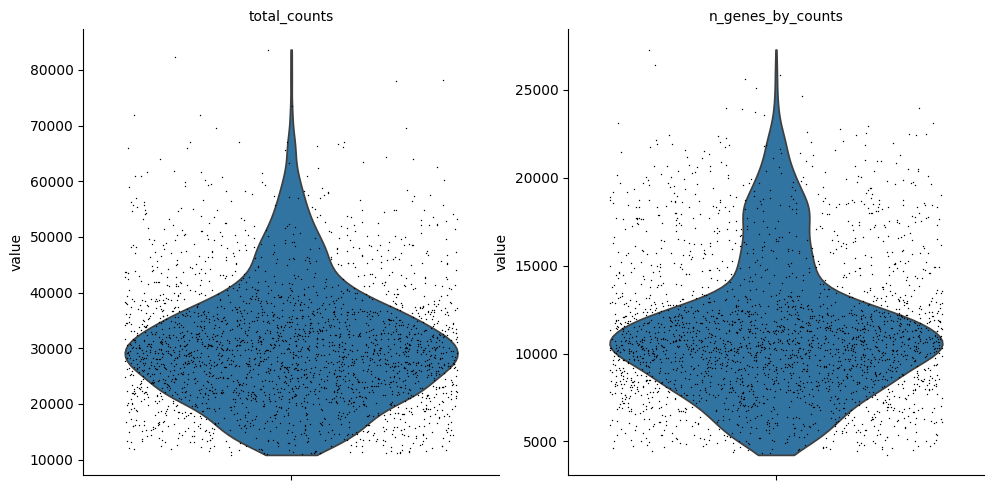

In [5]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

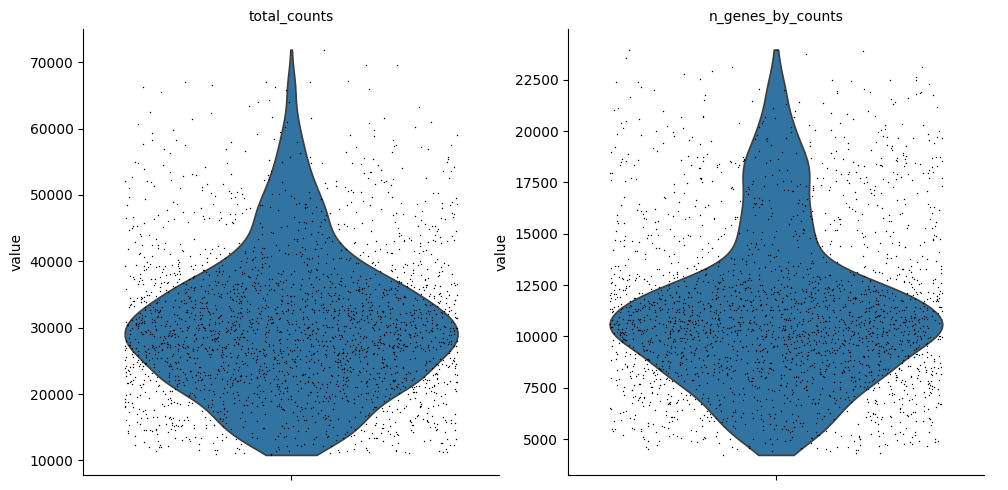

In [6]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 10) & (x <= 25000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 10) & (x <= 75000))
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

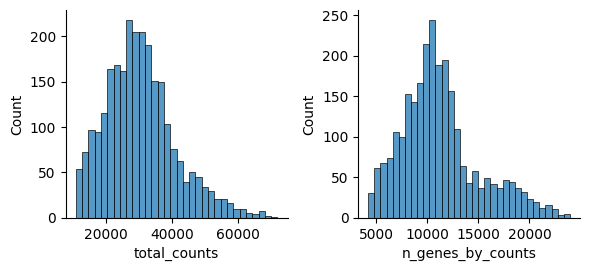

In [7]:
mu.pl.histogram(atac, ['total_counts','n_genes_by_counts'])

### ATAC-specific QC
There are a few expectations about how ATAC-seq data looks like as noted in the [hitchhiker’s guide to ATAC-seq data analysis](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#citeas) for instance.

#### Nucleosome signal
Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

Fetching Regions...: 100%|██████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


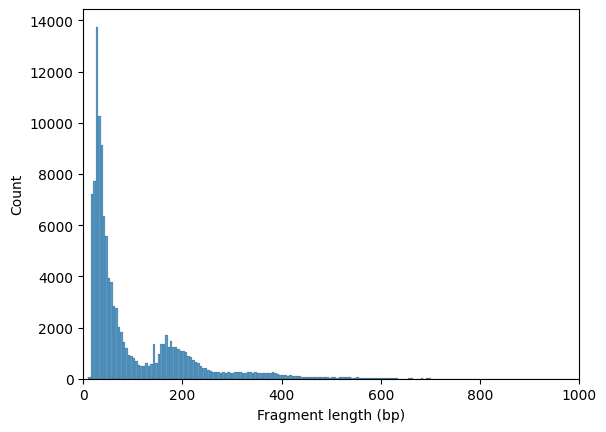

In [8]:
atac.obs['NS']=1
ac.tl.locate_fragments(atac, "AT209-72h-fresh-Combined_ATAC_Fragments.bed.gz")
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called nucleosome signal, and it can be estimated using a subset of fragments.

Reading Fragments: 100%|████████████████| 1000000/1000000 [00:03<00:00, 276516.50it/s]


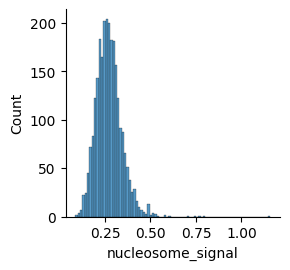

In [9]:
ac.tl.nucleosome_signal(atac, n=1e6)
mu.pl.histogram(atac, "nucleosome_signal")

### TSS enrichment
We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites will be loaded through the [TSS bed file](https://bd-rhapsody-public.s3.amazonaws.com/scripts-for-rhapsody-data/gencode.v42.primary_assembly.annotation-filtered_TSS.bed) (calculated from gencode v42 reference GTF) output:

In [10]:
tss_feature = pd.read_csv('gencode.v42.primary_assembly.annotation-filtered_TSS.bed', sep='\t', names=["Chromosome", "Start", "gene_id", "gene_name"])

In [11]:
tss = ac.tl.tss_enrichment(mdata, features = tss_feature, extend_upstream = 2000, extend_downstream = 2000) 
tss

Fetching Regions...: 100%|███████████████████████| 1999/1999 [00:18<00:00, 110.25it/s]


AnnData object with n_obs × n_vars = 2578 × 4001
    obs: 'Cell_Type_Experimental', 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

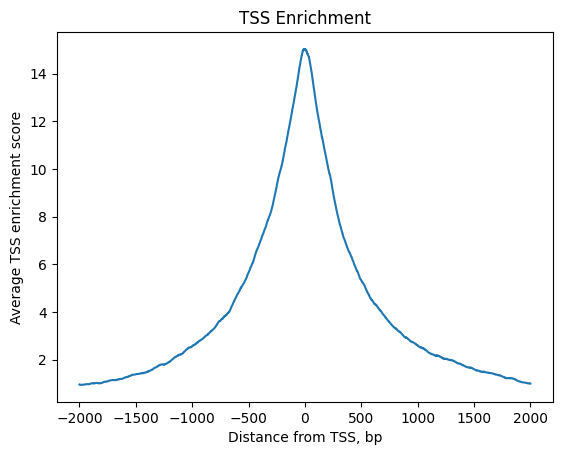

In [12]:
ac.pl.tss_enrichment(tss)

### Normalisation


In [13]:
# Save original counts
atac.layers["counts"] = atac.X

TF-IDF normalisation is implemented in the muon’s ATAC module:

In [14]:
ac.pp.tfidf(atac, scale_factor=1e4)

Here we will use the same log-normalisation and PCA that we are used to from scRNA-seq analysis. We notice on this data it yields PC & UMAP spaces similar to the one generated on scRNA-seq counts.

In [15]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

### Feature selection
We will label highly variable peaks that we’ll use for downstream analysis.

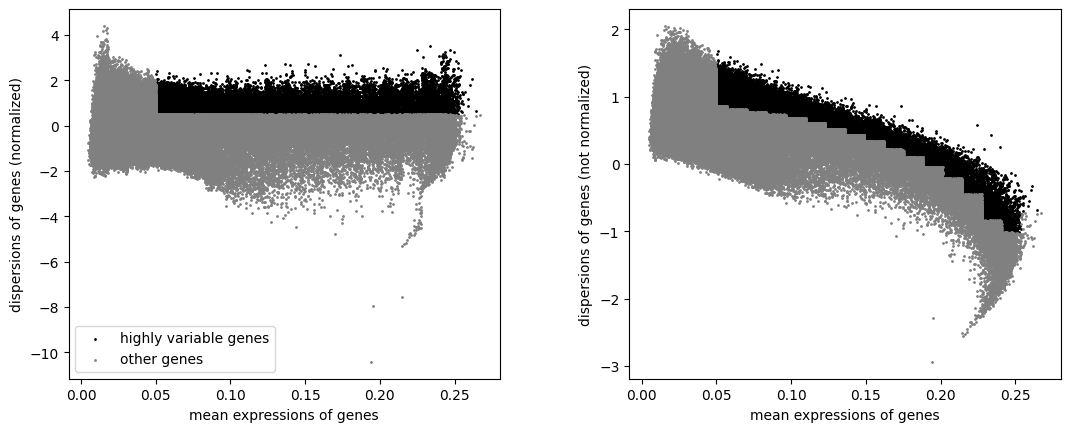

In [16]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [17]:
np.sum(atac.var.highly_variable)

22272

### Scaling
For uniformity, and for consequent visualisation, we’ll save log-transformed counts in a .raw slot:

In [18]:
atac.raw = atac

## Analysis

After filtering out low-quality cells, normalising the counts matrix, and selecting highly varianbe peaks, we can already use this data for multimodal integration.

However, as in the case of gene expression, we will study this data individually first and will run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types. This might be useful later to compare cell type definition between modalities.

### LSI
When working on TF-IDF counts, sc.tl.pca or ac.tl.lsi can be used to get latent components, e.g.:



In [19]:
ac.tl.lsi(atac)

We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it:

In [20]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

The respective neighbourhood graph can be generated with sc.tl.neighbors:

In [21]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

### PCA
For this notebook, we are using PCA on the log-normalised counts in atac.X as described above.

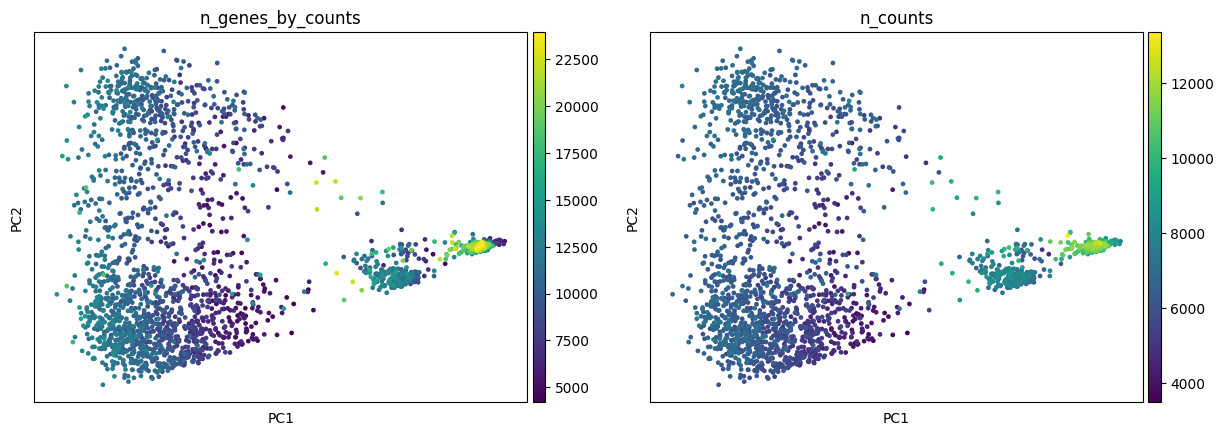

In [22]:
sc.pp.scale(atac)
sc.tl.pca(atac)

sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

With muon’s ATAC module, we can plot average values for cut counts in peaks of different types (promoter/distal) that are assigned to respective genes — just by providing gene names.

For that to work, we need a peak annotation table with gene -> peak correspondence. The Rhapsody Sequence Analysis Pipeline has already created a peak annotation table and inserted it into the expected location of the uns dictionary of the AnnData object.

In [23]:
atac.uns['atac']['peak_annotation']

# Alternatively add peak annotation from a TSV file from output
#ac.tl.add_peak_annotation(atac, annotation="your_run_peak_annotation.tsv")

peak  distance   peak_type
gene                                                           
                     GL000008.2:1053-1259         0  intergenic
                     GL000008.2:1871-3526         0  intergenic
                   GL000194.1:55964-56218         0  intergenic
ENSG00000277400  GL000194.1:101229-101797    -48207      distal
MAFIP            GL000194.1:101229-101797    -48203      distal
...                                   ...       ...         ...
                   chrY:56734668-56734914         0  intergenic
                   chrY:56763401-56763649         0  intergenic
                   chrY:56830925-56831326         0  intergenic
                   chrY:56834214-56834532         0  intergenic
                   chrY:56836627-56837229         0  intergenic

[226315 rows x 3 columns]

Now we can plot average cut values in peaks corresponding to genes just by providing a gene name. By default, values in atac.raw are used for plotting.


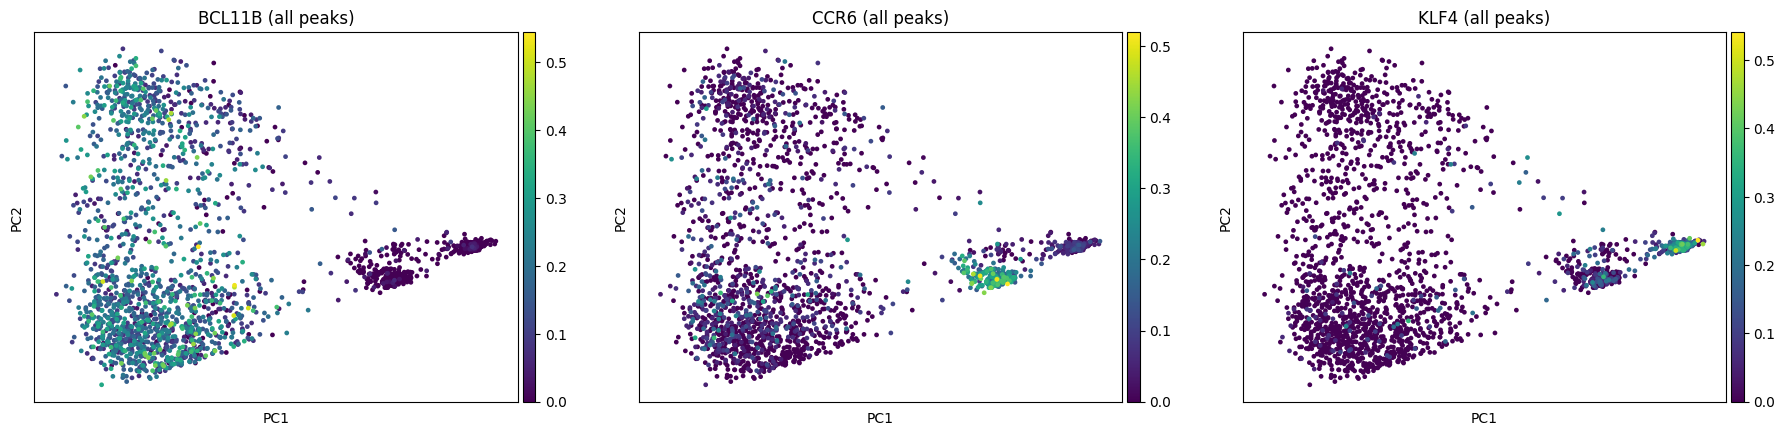

In [24]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

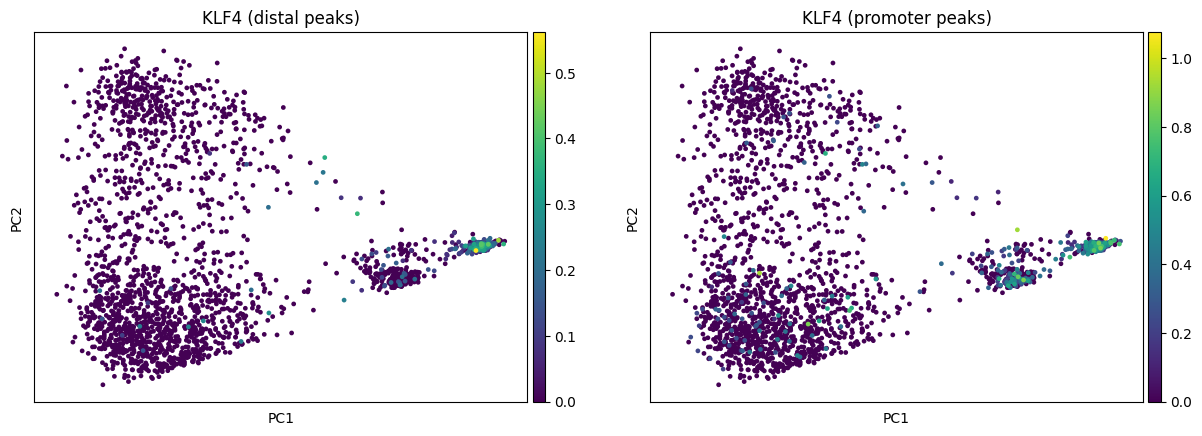

In [25]:
# We can also average peaks of each type separately:
ac.pl.pca(atac, color="KLF4", average="peak_type")

We see how this component space here resembles the one based on gene expression from the previous notebook. Looking at top loadings of first two components, we see how peaks linked to BCL11B (ENSG00000127152) and KLF4 (ENSG00000136826) demarcate lympohoid / myeloid axis while peaks linked to CCR6 (ENSG00000112486) define B cell axis.

Now we will compute a neighbourhood graph for cells that we’ll use for clustering later on.

In [26]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

### Non-linear dimensionality reduction and clustering

UMAP and TSNE coordiates were pre-loaded in the output muon object from the pipeline. We can plot dimentionality reduction plots directly:

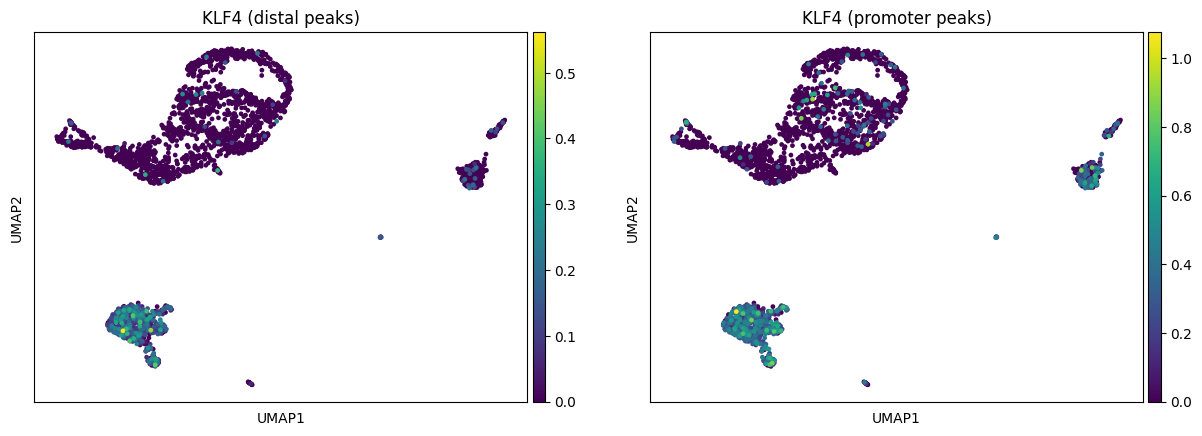

In [27]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

Or, we can generate the UMAP coordinates by perform non-linear dimensionality reduction. This step is required if further integrated analysis is desired.

In [28]:
sc.tl.leiden(atac, resolution=.5)

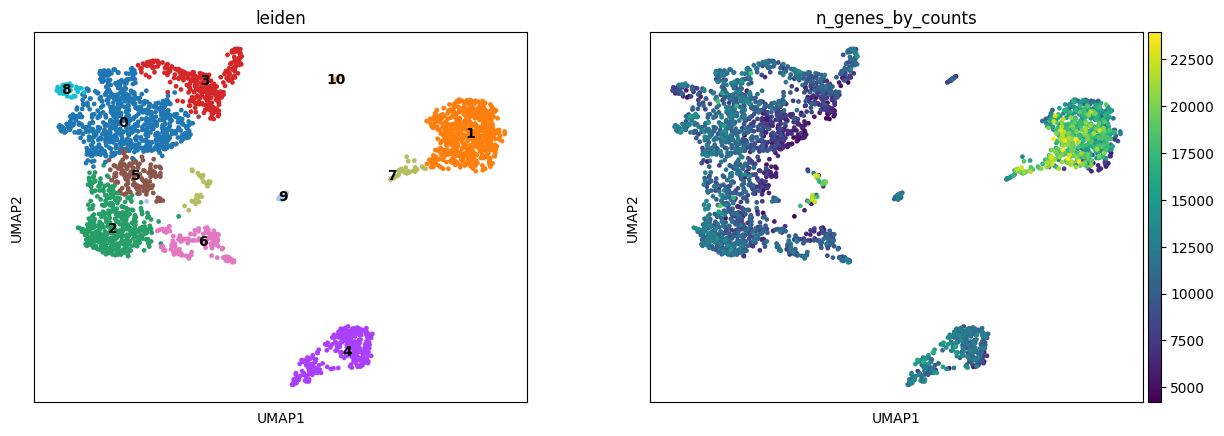

In [29]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

### Marker genes and celltypes
We will now define cell types based on chromatin accessibility.

In [30]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test', add_peak_type=True)

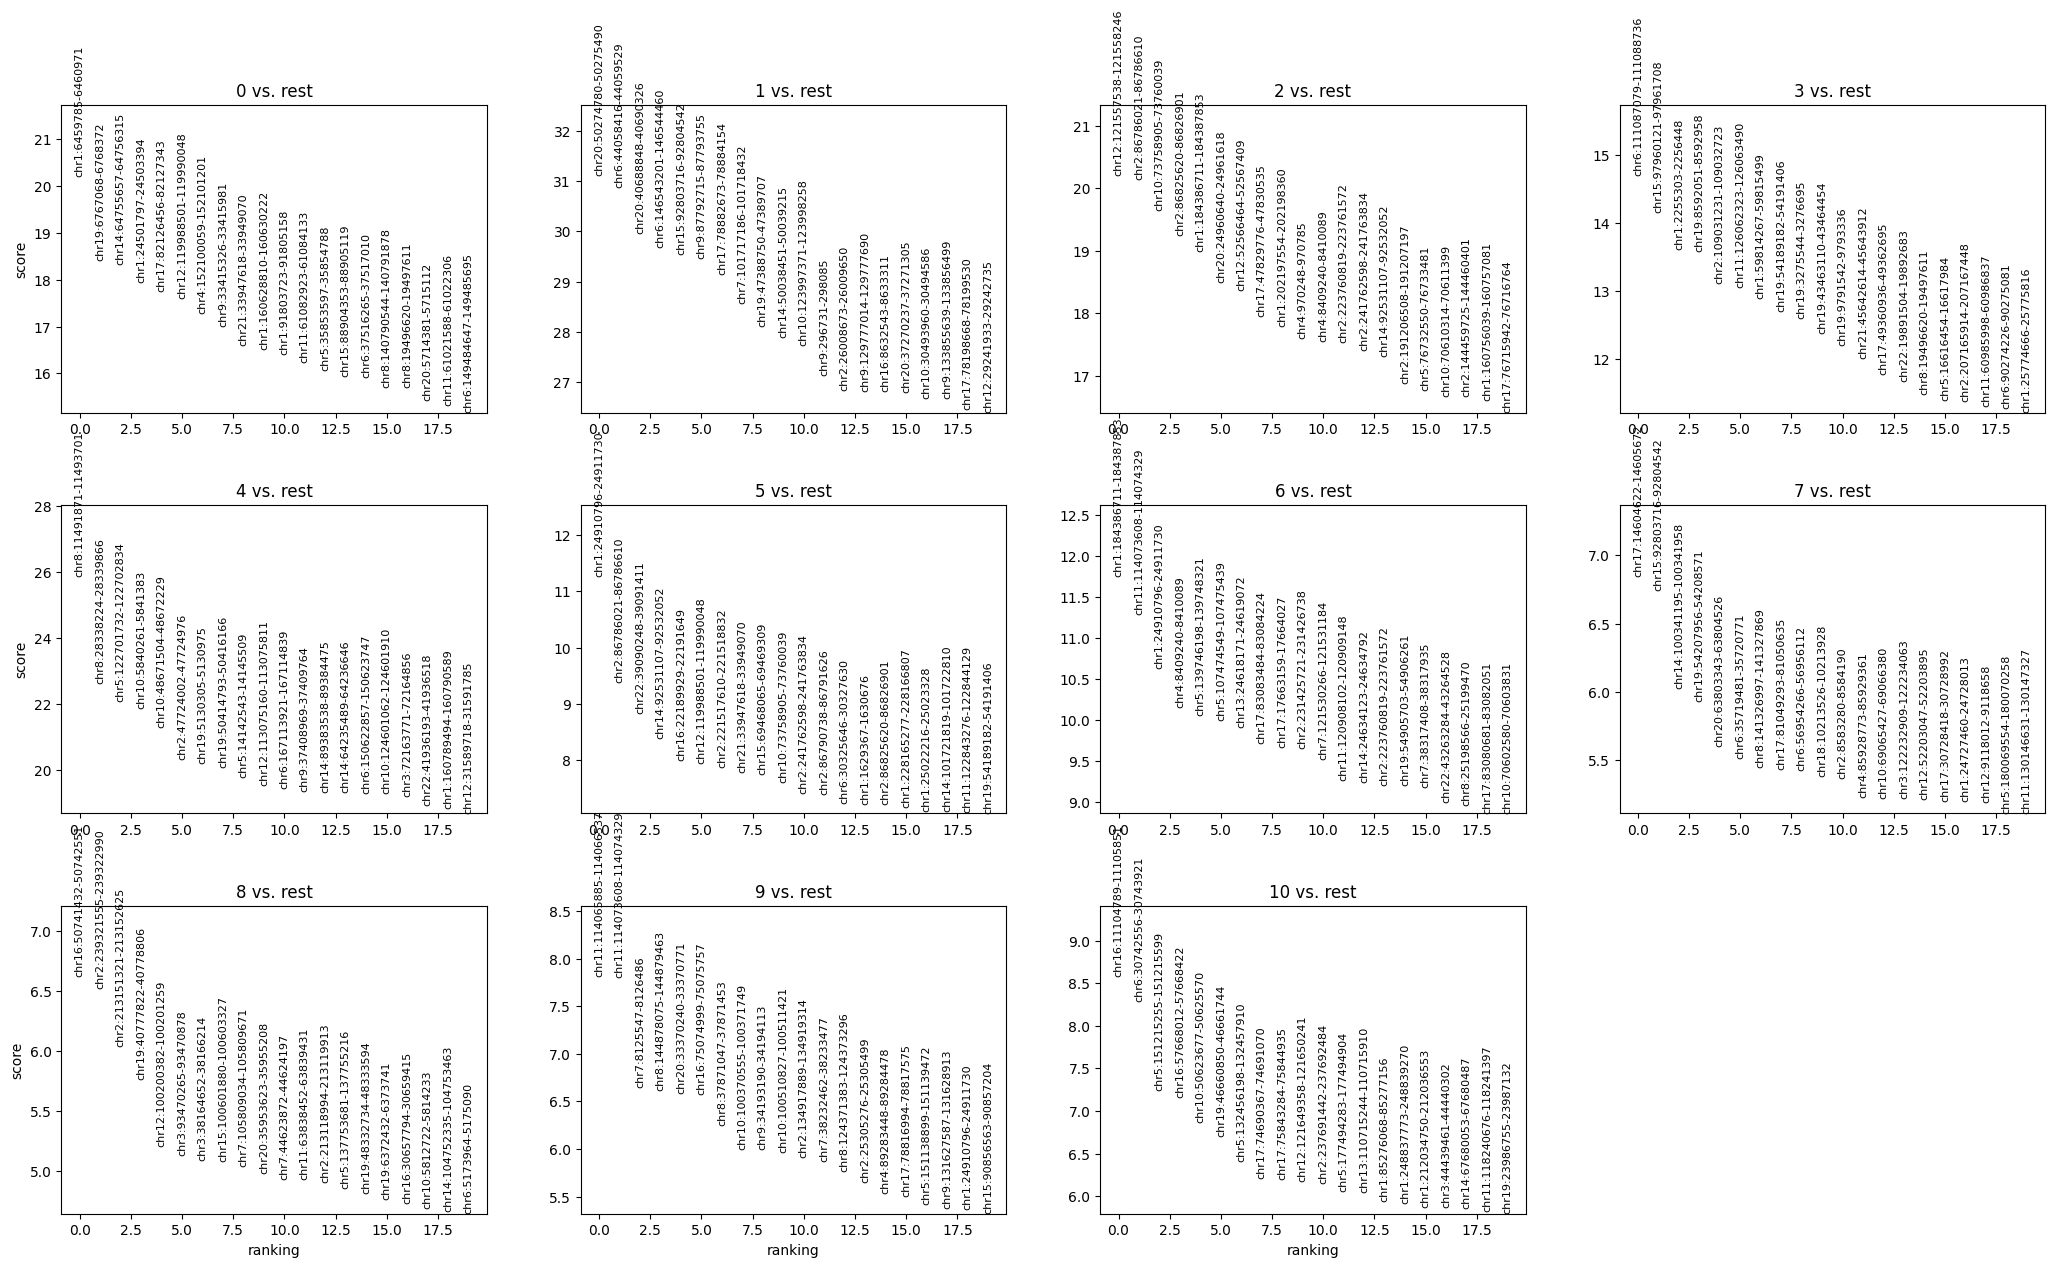

In [31]:
sc.pl.rank_genes_groups(atac, n_genes=20, sharey=False)

In [32]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n                                          0_g  \
0       chr1:6459785-6460971     ESPN, ENSG00000231868, TNFRSF25, PLEKHG5   
1      chr19:6767068-6768372                SH2D3A, ENSG00000269680, VAV1   
2    chr14:64755657-64756315                                PLEKHG3, SPTB   
3     chr1:24501797-24503394                      RCAN3AS, RCAN3, RCAN3AS   
4    chr17:82126456-82127343                                       CCDC57   
5  chr12:119988501-119990048                                       BICDL1   
6   chr4:152100059-152101201                   LINC02273, ENSG00000287504   
7     chr9:33415326-33415981                        AQP7, ENSG00000286322   
8    chr21:33947618-33949070  LINC00649, ENSG00000249209, ENSG00000273102   
9   chr1:160628810-160630222                                       SLAMF1   

            0_p                       1_n  \
0  1.711066e-75   chr20:50274780-50275490   
1  9.409860e-67    chr6:44058416-44059529   
2  6.077615e-63   chr20:40688848-40690326   
3  2.427987e-63  chr6:146543201-146544460   
4  1.261048e-61   chr15:92803716-92804542   
5  3.854089e-62    chr9:87792715-87793755   
6  3.685223e-59   chr17:78882673-78884154   
7  2.561256e-56  chr7:101717186-101718432   
8  1.185608e-55   chr19:47388750-47389707   
9  2.863876e-54   chr14:50038451-50039215   

                                                 1_g            1_p  \
0                                 PELATON, LINC01270  3.237181e-126   
1                             ENSG00000231881, SCIRT  2.759811e-126   
2                              MAFB, ENSG00000229771  7.907499e-122   
3                                              RAB32  2.105610e-120   
4  FAM174B, ENSG00000274215, ENSG00000258922, CHA...  2.073764e-120   
5                                             CTSL3P  5.815125e-118   
6                   TIMP2, CEP295NL, ENSG00000267491  1.507278e-119   
7                                                     5.221806e-113   
8                                       DHX34, MEIS3  1.104613e-110   
9                                          LINC01588  2.311525e-112   

                         2_n                                            2_g  \
0  chr12:121557538-121558246                                          KDM2B   
1     chr2:86786021-86786610                                   RMND5A, CD8A   
2    chr10:73758905-73760039                                  SEC24C, FUT11   
3     chr2:86825620-86826901                                           CD8A   
4   chr1:184386711-184387853  C1orf21, C1orf21-DT, C1orf21, ENSG00000230470   
5    chr20:24960640-24961618                                           CST7   
6    chr12:52566464-52567409                                   KRT71, KRT74   
7    chr17:47829776-47830535                  MRPL10, OSBPL7, LRRC46, SCRN2   
8   chr1:202197554-202198360                                           LGR6   
9         chr4:970248-970785                            TMEM175, DGKQ, IDUA   

            2_p                        3_n  ...           7_p  \
0  1.795831e-64   chr6:111087079-111088736  ...  4.521863e-09   
1  4.223770e-65    chr15:97960121-97961708  ...  6.384007e-09   
2  1.112163e-63       chr1:2255303-2256448  ...  1.099268e-07   
3  1.329114e-60      chr19:8592051-8592958  ...  1.515726e-07   
4  5.900911e-60   chr2:109031231-109032723  ...  5.508066e-07   
5  2.091289e-57  chr11:126062323-126063490  ...  7.407966e-07   
6  8.651745e-56     chr1:59814267-59815499  ...  1.000126e-06   
7  1.415517e-55    chr19:54189182-54191406  ...  1.072280e-06   
8  3.819403e-53      chr19:3275544-3276695  ...  1.073581e-06   
9  1.071179e-52    chr19:43463110-43464454  ...  1.297376e-06   

                         8_n  \
0    chr16:50741432-50742551   
1   chr2:239321555-239322990   
2   chr2:213151321-213152625   
3    chr19:40777822-40778806   
4  chr12:100200382-100201259   
5     chr3:93470265-93470878   
6     chr3:38164652-38166214   
7  chr15:100601880-100603327   
8   chr7:105809034-105809

Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters: likely noise cluster in 9 and 10.

In [33]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9", "10"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["9"])]
# but doesn't copy the object

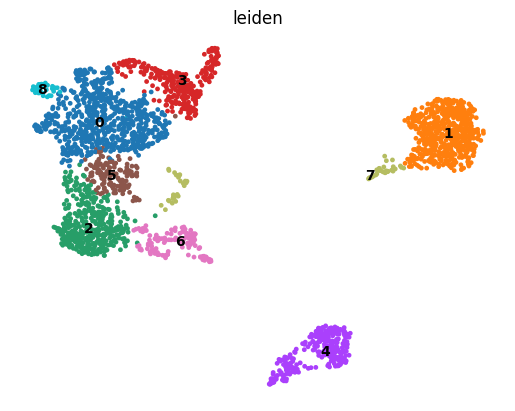

In [34]:
sc.pl.umap(atac, color="leiden", legend_loc="on data", frameon=False)

In [35]:
new_cluster_names = {
    "1": "CD16 mono", "2": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ memory T", "8": "CD4+ activated T", "6": "NK",
    "0": "CD4+ memory T", "4": "B", "7": "intermediate mono"
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

The Rhapsody Sequence Analysis Pipeline includes a per-cell experimental immune cell classifier, whose annotation is built into the muon object as "Cell_Type_Experimental".  We can see how this compares to manually annotated leiden clusters:

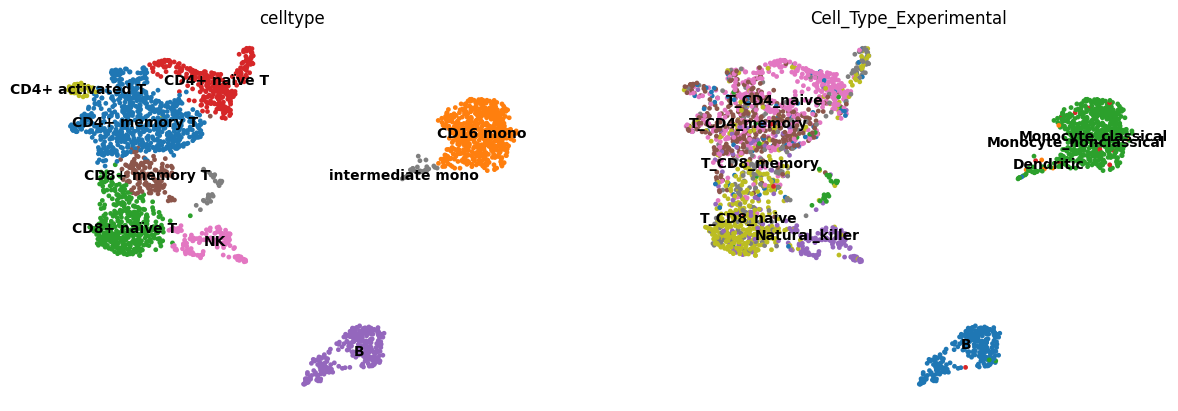

In [36]:
sc.pl.umap(atac, color=["celltype", "Cell_Type_Experimental"], legend_loc="on data", frameon=False)

In [37]:
# visualise some marker genes across cell types using dotplot.
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8']

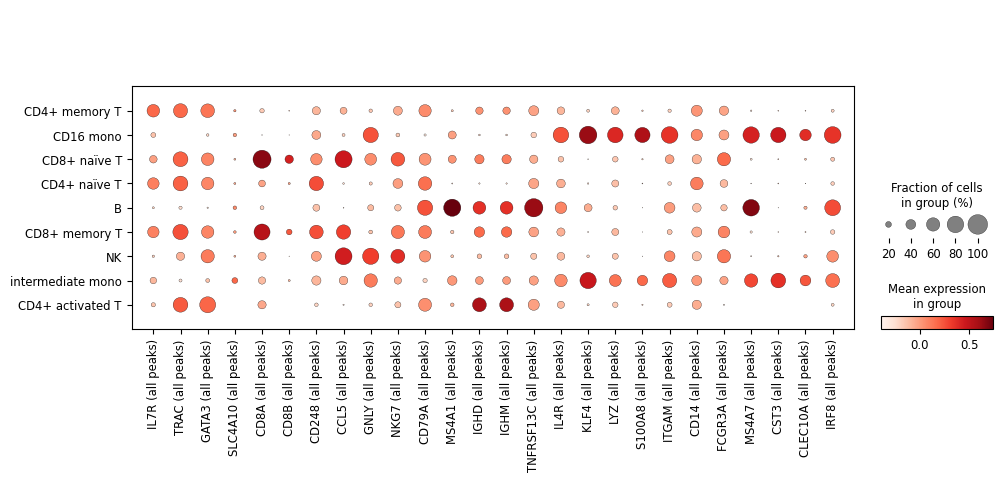

In [38]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

In [39]:
# Save the filtered data with the newly created annotations in a separate file
# This will make it easy to return to this point by loading this new h5mu file
mdata_filtered_annotated = mu.MuData({'atac': atac})
results_file = 'AT209-72h-fresh-Combined_analyzed.h5mu'  # the file that will store the analysis results
mdata_filtered_annotated.write(results_file, compression='gzip')